In [ ]:
!apt-get install openjdk-11-jdk -y
!wget -q https://archive.apache.org/dist/spark/spark-3.5.1/spark-3.5.1-bin-hadoop3.tgz
!tar xf spark-3.5.1-bin-hadoop3.tgz
!pip install -q findspark pyspark

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  fonts-dejavu-core fonts-dejavu-extra libatk-wrapper-java
  libatk-wrapper-java-jni libxt-dev libxtst6 libxxf86dga1 openjdk-11-jre
  x11-utils
Suggested packages:
  libxt-doc openjdk-11-demo openjdk-11-source visualvm mesa-utils
The following NEW packages will be installed:
  fonts-dejavu-core fonts-dejavu-extra libatk-wrapper-java
  libatk-wrapper-java-jni libxt-dev libxtst6 libxxf86dga1 openjdk-11-jdk
  openjdk-11-jre x11-utils
0 upgraded, 10 newly installed, 0 to remove and 35 not upgraded.
Need to get 6,920 kB of archives.
After this operation, 16.9 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 fonts-dejavu-core all 2.37-2build1 [1,041 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 fonts-dejavu-extra all 2.37-2build1 [2,041 kB]
Get:3 http://archive.ubuntu.com/ubuntu jam

In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.5.1-bin-hadoop3"

In [ ]:
import findspark
findspark.init()

In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("ColabPySpark").getOrCreate()

In [ ]:
data = [(1, "Apple", 100),
        (2, "Banana", 30),
        (3, "Orange", 70)]

df = spark.createDataFrame(data, ["id", "fruit", "price"])
df.show()

+---+------+-----+
| id| fruit|price|
+---+------+-----+
|  1| Apple|  100|
|  2|Banana|   30|
|  3|Orange|   70|
+---+------+-----+



In [ ]:
!wget -O titanic.csv https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv

--2025-06-25 07:23:31--  https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 60302 (59K) [text/plain]
Saving to: ‘titanic.csv’

titanic.csv         100%[===================>]  58.89K  --.-KB/s    in 0.01s   

2025-06-25 07:23:31 (4.15 MB/s) - ‘titanic.csv’ saved [60302/60302]



In [ ]:
df = spark.read.csv("titanic.csv", header=True, inferSchema=True)
df.printSchema()
df.show(5)

root
 |-- PassengerId: integer (nullable = true)
 |-- Survived: integer (nullable = true)
 |-- Pclass: integer (nullable = true)
 |-- Name: string (nullable = true)
 |-- Sex: string (nullable = true)
 |-- Age: double (nullable = true)
 |-- SibSp: integer (nullable = true)
 |-- Parch: integer (nullable = true)
 |-- Ticket: string (nullable = true)
 |-- Fare: double (nullable = true)
 |-- Cabin: string (nullable = true)
 |-- Embarked: string (nullable = true)

+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+-----+--------+
|PassengerId|Survived|Pclass|                Name|   Sex| Age|SibSp|Parch|          Ticket|   Fare|Cabin|Embarked|
+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+-----+--------+
|          1|       0|     3|Braund, Mr. Owen ...|  male|22.0|    1|    0|       A/5 21171|   7.25| NULL|       S|
|          2|       1|     1|Cumings, Mrs. Joh...|female|38.0|    1|    0|   

In [ ]:
#Select and Filter
df.select("Name", "Age", "Sex", "Survived").filter("Age > 50").show(5)

+--------------------+----+------+--------+
|                Name| Age|   Sex|Survived|
+--------------------+----+------+--------+
|McCarthy, Mr. Tim...|54.0|  male|       0|
|Bonnell, Miss. El...|58.0|female|       1|
|Hewlett, Mrs. (Ma...|55.0|female|       1|
|Wheadon, Mr. Edwa...|66.0|  male|       0|
|Ostby, Mr. Engelh...|65.0|  male|       0|
+--------------------+----+------+--------+
only showing top 5 rows



In [ ]:
#Group by Gender and Survival
df.groupBy("Sex", "Survived").count().show()

+------+--------+-----+
|   Sex|Survived|count|
+------+--------+-----+
|  male|       0|  468|
|female|       1|  233|
|female|       0|   81|
|  male|       1|  109|
+------+--------+-----+



In [ ]:
#Average Age by Class
df.groupBy("Pclass").avg("Age").show()

In [ ]:
#SQL Example
df.createOrReplaceTempView("titanic")
spark.sql("SELECT Sex, COUNT(*) FROM titanic WHERE Survived = 1 GROUP BY Sex").show()

+------+--------+
|   Sex|count(1)|
+------+--------+
|female|     233|
|  male|     109|
+------+--------+



In [ ]:
#Missing Data Analysis

from pyspark.sql.functions import col, count, when

df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+-----------+--------+------+----+---+---+-----+-----+------+----+-----+--------+
|PassengerId|Survived|Pclass|Name|Sex|Age|SibSp|Parch|Ticket|Fare|Cabin|Embarked|
+-----------+--------+------+----+---+---+-----+-----+------+----+-----+--------+
|          0|       0|     0|   0|  0|177|    0|    0|     0|   0|  687|       2|
+-----------+--------+------+----+---+---+-----+-----+------+----+-----+--------+



In [ ]:
#Survival Rate by Gender

df.groupBy("Sex", "Survived").count().orderBy("Sex", "Survived").show()

+------+--------+-----+
|   Sex|Survived|count|
+------+--------+-----+
|female|       0|   81|
|female|       1|  233|
|  male|       0|  468|
|  male|       1|  109|
+------+--------+-----+



In [ ]:
#Average Age and Fare by Class

df.groupBy("Pclass").agg({"Age": "avg", "Fare": "avg"}).show()

+------+------------------+------------------+
|Pclass|          avg(Age)|         avg(Fare)|
+------+------------------+------------------+
|     1|38.233440860215055| 84.15468749999992|
|     3| 25.14061971830986|13.675550101832997|
|     2| 29.87763005780347| 20.66218315217391|
+------+------------------+------------------+



In [ ]:
#Filter Elderly Survivors (Age > 60 and Survived)

df.filter((col("Age") > 60) & (col("Survived") == 1)).select("Name", "Age", "Sex", "Pclass").show()

+--------------------+----+------+------+
|                Name| Age|   Sex|Pclass|
+--------------------+----+------+------+
|Andrews, Miss. Ko...|63.0|female|     1|
|Turkula, Mrs. (He...|63.0|female|     3|
|  Harris, Mr. George|62.0|  male|     2|
|Barkworth, Mr. Al...|80.0|  male|     1|
|Stone, Mrs. Georg...|62.0|female|     1|
+--------------------+----+------+------+



In [ ]:
# Feature Engineering – Create Family Size Column

df = df.withColumn("FamilySize", col("SibSp") + col("Parch") + 1)
df.select("Name", "FamilySize").show(5)

+--------------------+----------+
|                Name|FamilySize|
+--------------------+----------+
|Braund, Mr. Owen ...|         2|
|Cumings, Mrs. Joh...|         2|
|Heikkinen, Miss. ...|         1|
|Futrelle, Mrs. Ja...|         2|
|Allen, Mr. Willia...|         1|
+--------------------+----------+
only showing top 5 rows



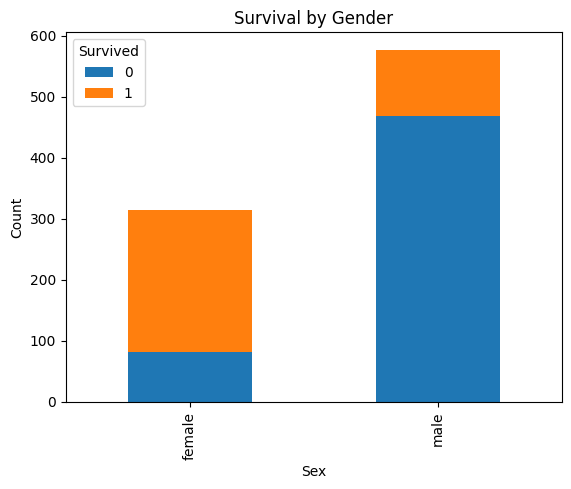

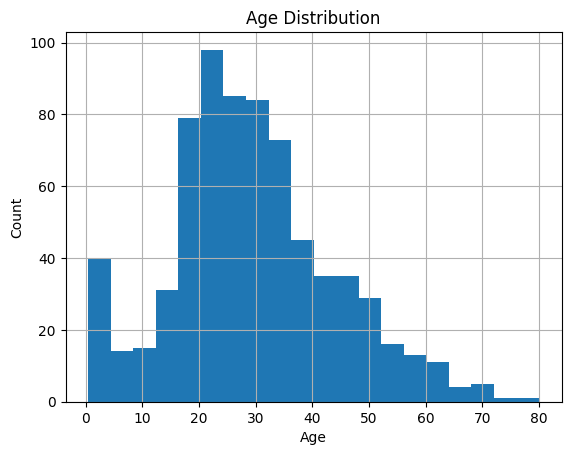

In [ ]:
#Visualization

import pandas as pd
import matplotlib.pyplot as plt

pandas_df = df.select("Survived", "Sex", "Pclass", "Age", "Fare", "FamilySize").toPandas()

# Plot survival count by gender
pandas_df.groupby(["Sex", "Survived"]).size().unstack().plot(kind="bar", stacked=True)
plt.title("Survival by Gender")
plt.ylabel("Count")
plt.show()

# Plot histogram of Age
pandas_df["Age"].hist(bins=20)
plt.title("Age Distribution")
plt.xlabel("Age")
plt.ylabel("Count")
plt.show()

In [ ]:
#Distribution of Passenger Classes

df.groupBy("Pclass").count().orderBy("Pclass").show()

+------+-----+
|Pclass|count|
+------+-----+
|     1|  216|
|     2|  184|
|     3|  491|
+------+-----+



In [ ]:
#Survival Rate by Class

df.groupBy("Pclass").agg({"Survived": "avg"}).withColumnRenamed("avg(Survived)", "SurvivalRate").show()

+------+-------------------+
|Pclass|       SurvivalRate|
+------+-------------------+
|     1| 0.6296296296296297|
|     3|0.24236252545824846|
|     2|0.47282608695652173|
+------+-------------------+



In [ ]:
#Survival Rate by Embarked Port

df.groupBy("Embarked").agg({"Survived": "avg"}).withColumnRenamed("avg(Survived)", "SurvivalRate").show()

+--------+-------------------+
|Embarked|       SurvivalRate|
+--------+-------------------+
|       Q|0.38961038961038963|
|    NULL|                1.0|
|       C| 0.5535714285714286|
|       S|0.33695652173913043|
+--------+-------------------+



In [ ]:
#Distribution of Fares (by Class)

df.groupBy("Pclass").agg({"Fare": "avg", "Fare": "max", "Fare": "min"}).show()


+------+---------+
|Pclass|min(Fare)|
+------+---------+
|     1|      0.0|
|     3|      0.0|
|     2|      0.0|
+------+---------+



In [ ]:
#Age Grouping

from pyspark.sql.functions import when

df = df.withColumn("AgeGroup", when(col("Age") < 13, "Child")
                               .when((col("Age") >= 13) & (col("Age") < 20), "Teen")
                               .when((col("Age") >= 20) & (col("Age") < 60), "Adult")
                               .when(col("Age") >= 60, "Senior")
                               .otherwise("Unknown"))
df.select("Name", "Age", "AgeGroup").show(5)

+--------------------+----+--------+
|                Name| Age|AgeGroup|
+--------------------+----+--------+
|Braund, Mr. Owen ...|22.0|   Adult|
|Cumings, Mrs. Joh...|38.0|   Adult|
|Heikkinen, Miss. ...|26.0|   Adult|
|Futrelle, Mrs. Ja...|35.0|   Adult|
|Allen, Mr. Willia...|35.0|   Adult|
+--------------------+----+--------+
only showing top 5 rows



In [ ]:
#Survival Rate by Age Group

df.groupBy("AgeGroup").agg({"Survived": "avg"}).withColumnRenamed("avg(Survived)", "SurvivalRate").show()

+--------+------------------+
|AgeGroup|      SurvivalRate|
+--------+------------------+
|  Senior|0.2692307692307692|
|    Teen|0.4105263157894737|
| Unknown|0.2937853107344633|
|   Adult|0.3893129770992366|
|   Child|0.5797101449275363|
+--------+------------------+



In [ ]:
from pyspark.sql.functions import when

df = df.withColumn("AgeGroup", when(col("Age") < 13, "Child")
                               .when((col("Age") >= 13) & (col("Age") < 20), "Teen")
                               .when((col("Age") >= 20) & (col("Age") < 60), "Adult")
                               .when(col("Age") >= 60, "Senior")
                               .otherwise("Unknown"))

In [ ]:
pandas_df = df.select("Survived", "Sex", "Pclass", "Age", "Fare", "FamilySize", "AgeGroup").toPandas()

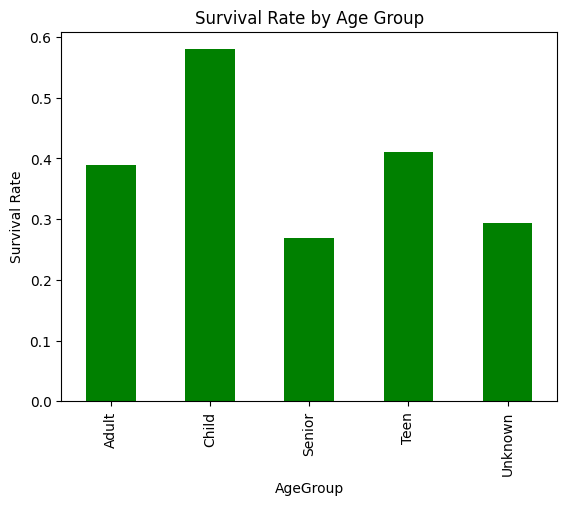

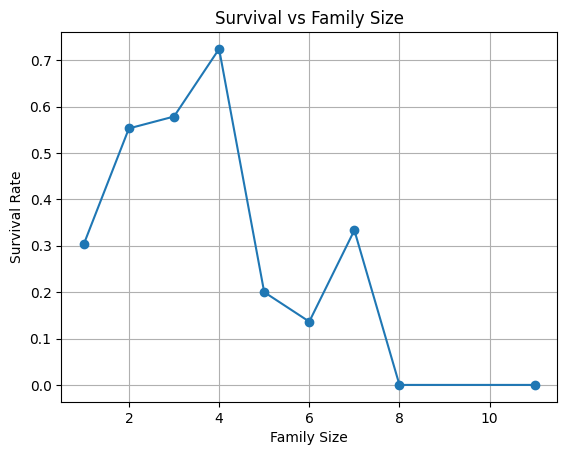

In [ ]:
# Survival rate by age group
pandas_df.groupby("AgeGroup")["Survived"].mean().plot(kind="bar", color="green")
plt.title("Survival Rate by Age Group")
plt.ylabel("Survival Rate")
plt.show()

# Family size vs survival
pandas_df.groupby("FamilySize")["Survived"].mean().plot(marker='o')
plt.title("Survival vs Family Size")
plt.ylabel("Survival Rate")
plt.xlabel("Family Size")
plt.grid()
plt.show()